This notebook will be mainly used for the capstone project - Applied Data Science Course at Coursera

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from bs4 import BeautifulSoup
import requests
import geocoder
from pandas.io.json import json_normalize 
import folium
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


In [2]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
response.status_code

200

In [3]:
#response.text

In [4]:
wiki_bs = BeautifulSoup(response.text, 'lxml')
#wiki_bs.prettify()

In [5]:
table = wiki_bs.find('table', class_="wikitable sortable").find_all('tr')
len(table)

289

In [6]:
#table[0].select('td')[0].text
#table[3].select('td')[2].text
#row1 = table[3]

#print(str(row1.select('td')[2].text) if (row1.select('td')[2].text!='Not assigned\n') else None)

In [7]:
df_Toronto = pd.DataFrame(columns=['borough', 'neighborhood'])
dict_Toronto={}
for row in table:
    postal = 1
    borough = 1
    neighborhood = 1
    if row.select('td'):
        if (row.select('td')[1].text.rstrip()!='Not assigned'):
            postal = row.select('td')[0].text.rstrip()
            borough = row.select('td')[1].text.rstrip()
            neighborhood = row.select('td')[2].text.rstrip() if (row.select('td')[2].text.rstrip()!='Not assigned') else borough
            if postal in dict_Toronto:
                neighborhood = dict_Toronto[postal]['neighborhood'] + ', ' + neighborhood
            dict_Toronto[postal] = {'borough':borough, 'neighborhood':neighborhood}
            #print (postal, borough, neighborhood)
df_Toronto = df_Toronto.from_dict(dict_Toronto, orient='columns').T
#append({'p_code':postal, 'borough':borough, 'neighborhood':neighborhood}, ignore_index=True)
df_Toronto.head()
#len(dict_Toronto)

,borough,neighborhood
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Harbourfront, Regent Park"
M6A,North York,"Lawrence Heights, Lawrence Manor"
M7A,Queen's Park,Queen's Park


In [8]:
geocode = pd.read_csv('D:\Documents\Treinamentos\Geospatial_Coordinates.csv')
geocode.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
df_Toronto = df_Toronto.merge(geocode, how='left', left_index = True, right_on='Postal Code').reset_index().drop('index', axis = 1)
df_Toronto.head()

,borough,neighborhood,Postal Code,Latitude,Longitude
0,North York,Parkwoods,M3A,43.753259,-79.329656
1,North York,Victoria Village,M4A,43.725882,-79.315572
2,Downtown Toronto,"Harbourfront, Regent Park",M5A,43.654260,-79.360636
3,North York,"Lawrence Heights, Lawrence Manor",M6A,43.718518,-79.464763
4,Queen's Park,Queen's Park,M7A,43.662301,-79.389494


In [14]:
CLIENT_ID = 'INZQ0EGACTMXQ4VUGTVB2AQGSIFSK4BWNAG4G3WFQKEZ1RZY' # your Foursquare ID
CLIENT_SECRET = 'NTUVDXMGOKIKKXW4DYJCVLJYSGNENUC2EHYQ1B3TCZBAEQBO' # your Foursquare Secret
VERSION = '20190828'
#VERSION = '20180605' # Foursquare API version

In [15]:
def getNearbyVenues(p_code, latitudes, longitudes, radius=500, limit=200):
    
    venues_list=[]
    for code, lat, lng in zip(p_code, latitudes, longitudes):
       #print(code)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        #results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            code, 
            lat, 
            lng, 
            i['venue']['name'], 
            i['venue']['location']['lat'], 
            i['venue']['location']['lng'],  
            i['venue']['categories'][0]['name']) for i in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal_Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue_Name', 
                  'Venue_Lat', 
                  'Venue_Lng', 
                  'Venue_Cat']
    
    return(nearby_venues)

In [16]:
toronto_venues = getNearbyVenues(p_code = df_Toronto['Postal Code'],
                                latitudes = df_Toronto['Latitude'],
                                longitudes = df_Toronto['Longitude'])

toronto_venues.head()

,Postal_Code,Latitude,Longitude,Venue_Name,Venue_Lat,Venue_Lng,Venue_Cat
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M3A,43.753259,-79.329656,GreenWin pool,43.756232,-79.333842,Pool
3,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [17]:
venues_onehot = pd.get_dummies(toronto_venues[['Venue_Cat']], prefix="", prefix_sep="")
venues_onehot['Postal_Code'] = toronto_venues['Postal_Code']


In [18]:
i = 0
for row in venues_onehot.T.values:
    if (type(row.sum()) != str and row.sum() > 2):
        print (i, row.sum())
    i=i+1

6 3
8 27
10 5
11 11
13 7
14 17
15 4
18 5
20 8
21 49
22 18
23 43
24 5
27 4
30 18
31 9
32 3
34 4
36 17
37 4
39 3
40 25
41 14
43 11
44 4
45 29
46 12
47 6
48 4
50 3
51 105
55 10
56 7
57 25
61 33
62 15
63 193
70 8
71 3
72 8
74 9
75 16
77 7
81 5
82 17
83 8
84 14
86 20
87 8
88 4
90 3
92 4
93 4
94 10
99 11
100 34
104 4
105 5
107 3
109 4
110 9
111 4
112 4
113 12
114 15
117 14
121 24
122 4
123 4
124 4
125 7
126 3
128 7
129 17
130 24
131 32
132 17
139 3
146 44
147 3
150 20
151 15
155 6
156 3
157 51
158 33
159 5
162 8
163 3
165 6
166 4
168 16
169 12
176 6
177 4
179 16
180 13
181 4
185 3
187 7
189 5
191 7
192 4
193 8
194 6
195 5
196 3
201 48
202 3
204 9
205 19
206 51
208 5
209 8
210 5
212 3
213 3
215 3
216 25
217 8
218 4
219 4
220 61
224 8
225 5
226 41
227 3
228 4
229 25
230 4
231 12
234 6
235 4
236 8
239 4
241 10
242 4
243 14
244 6
247 21
249 8
250 3
251 25
254 4
258 15
260 23
261 13
263 4
264 3
265 5
266 3
268 20
269 4
271 11
273 10
274 4
275 5
276 13


In [19]:
venues_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[venues_columns]
venues_onehot.head()

,Postal_Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,

In [20]:
toronto_grouped = venues_onehot.groupby('Postal_Code').mean().reset_index()
toronto_grouped.head()


,Postal_Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,

In [21]:
i = 0
for row in toronto_grouped.T.values:
    if (type(row.sum()) != str and row.sum() > 0):
        print (i, row.sum())
    i=i+1

1 0.08333333333333333
2 0.011627906976744186
3 0.39215686274509803
4 0.058823529411764705
5 0.058823529411764705
6 0.11764705882352941
7 0.17647058823529413
8 0.11764705882352941
9 1.0794406346047933
10 0.029072006160954948
11 0.05
12 0.13220456282734616
13 0.021764705882352943
14 0.1570963998365414
15 0.4323111479715253
16 0.5386904761904762
17 0.16666666666666666
18 0.0625
19 0.08941460794844254
20 0.0625
21 0.2017689203027549
22 1.6401433363987634
23 2.347492530056932
24 1.794462088068226
25 1.882051282051282
26 0.02
27 0.25
28 0.04774794128177587
29 0.017543859649122806
30 0.01
31 0.21347774197398256
32 0.5421363227967002
33 0.03774794128177587
34 0.07792207792207792
35 0.05313255666639125
36 0.058823529411764705
37 0.3467654457494802
38 0.1729260935143288
39 0.043478260869565216
40 0.03538461538461539
41 1.2635113949260015
42 0.5620308411830106
43 0.05263157894736842
44 0.20924738887803185
45 0.23000000000000004
46 0.6972749821997428
47 0.4295408997810414
48 1.1833333333333333
49 

In [22]:
X = toronto_grouped.drop('Postal_Code', axis = 1)
#toronto_cluster.head()
X = X.values
X.shape

(99, 277)

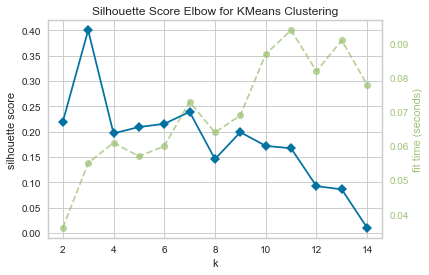

In [23]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,15), metric='silhouette'
)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [24]:
# set number of clusters
kclusters = 11

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 2, 2, 2, 4, 2, 1, 8, 2])

In [25]:
toronto_grouped['Labels11'] = kmeans.labels_
toronto_grouped.head()

,Postal_Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Labels11
0,M1B,0.0

In [26]:
toronto_grouped.shape

(99, 279)

In [27]:
toronto_grouped.Labels11.value_counts()

2     78
7      8
1      5
10     1
9      1
8      1
6      1
5      1
4      1
3      1
0      1
Name: Labels11, dtype: int64

In [28]:
df_map_toronto = toronto_grouped[['Postal_Code', 'Labels11']].merge(df_Toronto, how='left', left_on='Postal_Code', right_on = 'Postal Code')

In [29]:
df_map_toronto.head()

,Postal_Code,Labels11,borough,neighborhood,Postal Code,Latitude,Longitude
0,M1B,3,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,2,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,2,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,2,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,2,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [82]:
latitude = 43.653963
longitude = -79.387207
toronto_map = folium.Map(location = [latitude, longitude], zoom_start = 9)
cluster_colors = ['yellow', 'red', 'blue', 'purple', 'black', 'green', 'pink', 'brown', 'orange', 'gray', 'dark blue']

for lat, lng, code, cluster in zip(df_map_toronto['Latitude'], df_map_toronto['Longitude'], df_map_toronto['Postal_Code'], df_map_toronto['Labels11']):
    label = '{},{}'.format(code, cluster)
    label  = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = cluster_colors[cluster],
        fill = True,
        fill_color = cluster_colors[cluster],
        fill_opacity = 0.5,
        parse_html = False).add_to(toronto_map)
    
toronto_map

In [80]:
df = toronto_grouped.groupby('Labels11').mean()
for cluster in df.index:
    print("--CLUSTER "+str(cluster)+"----")
    temp = df[df.index == cluster]
    temp = df[df.index == cluster].T.reset_index()
    temp = temp.iloc[1:]
    temp.columns = ['venue','freq']
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 6})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
#temp

--CLUSTER 0----
                        venue  freq
0                        Bank   1.0
1           Afghan Restaurant   0.0
2  Modern European Restaurant   0.0
3               Moving Target   0.0
4               Movie Theater   0.0


--CLUSTER 1----
               venue      freq
0               Park  0.226667
1           Bus Line  0.196667
2             Bakery  0.090000
3        Swim School  0.066667
4  Mobile Phone Shop  0.050000


--CLUSTER 2----
            venue      freq
0     Coffee Shop  0.073713
1     Pizza Place  0.037801
2            Café  0.037102
3  Sandwich Place  0.029505
4   Grocery Store  0.023420


--CLUSTER 3----
                        venue  freq
0        Fast Food Restaurant   1.0
1           Afghan Restaurant   0.0
2  Modern European Restaurant   0.0
3                      Museum   0.0
4               Moving Target   0.0


--CLUSTER 4----
                        venue  freq
0                  Playground   1.0
1  Modern European Restaurant   0.0
2                 

In [12]:
# initialize your variable to None
lat_lng_coords = None
i=0
# loop until you get the coordinates
while(lat_lng_coords is None and i<200):
    #g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
    print(i)
    #g = geocoder.google('M3A, Toronto, Ontario')
    g = geocoder.google('Mountain View, CA')
    lat_lng_coords = g.latlng
    i=i+1
    
if lat_lng_coords:
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [13]:
from geopy.geocoders import Nominatim
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Toronto, ON are 43.653963, -79.387207.
